In [1]:
import torch
import contextlib
from torch.optim import Optimizer
from gptopt.train import train
from gptopt.optim.utils import get_scheduler, get_optimizer
from gptopt.utils import hash_config, set_seed, get_worker_info
from gptopt.model import load_model
from gptopt.data.data_utils import get_data_dir
from gptopt.dataloader import ShardedDataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import copy
import json
import os
import wandb
import hydra
import time
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from gptopt.train import Logging, eval_validation_loss
from gptopt.gpt_model import CausalSelfAttention
from gptopt.utils import get_worker_info, save_checkpoint, load_checkpoint
from hydra import initialize, compose 
from types import SimpleNamespace

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16}
from gptopt.optim.pdhg import pdhg_method_AB, prox_l1, check_dual_feasible, AttnPDAdamW

from utils_pdhg import *


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pd_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_pd_adamw and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, qk_lr_scale=1.0, max_norm_tr=0.001, pdhg_iters=200, 
    momentum=False, diag_scaling=True, accel=False, pd_type='fista'
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
diag scaling: True
lamb_max=2.1732e+01, mu_reg=1.0313e-02, mu_max=1.0313e-01
lamb_max=2.1714e+01, mu_reg=2.8646e-03, mu_max=2.8646e-02
lamb_max=2.1721e+01, mu_reg=1.8532e-03, mu_max=1.8532e-02
lamb_max=2.1729e+01, mu_reg=1.5035e-03, mu_max=1.5035e-

In [3]:
# Rebuild the config with the same overrides used in main()
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pd_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

with initialize(config_path="../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)

# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw/bs-4-lr-0.001-wd-0/attn_pd_adamw-lr-0.001-constant-linear-319a6051f437987e6a3b9b8e629f8192.json


iteration=0


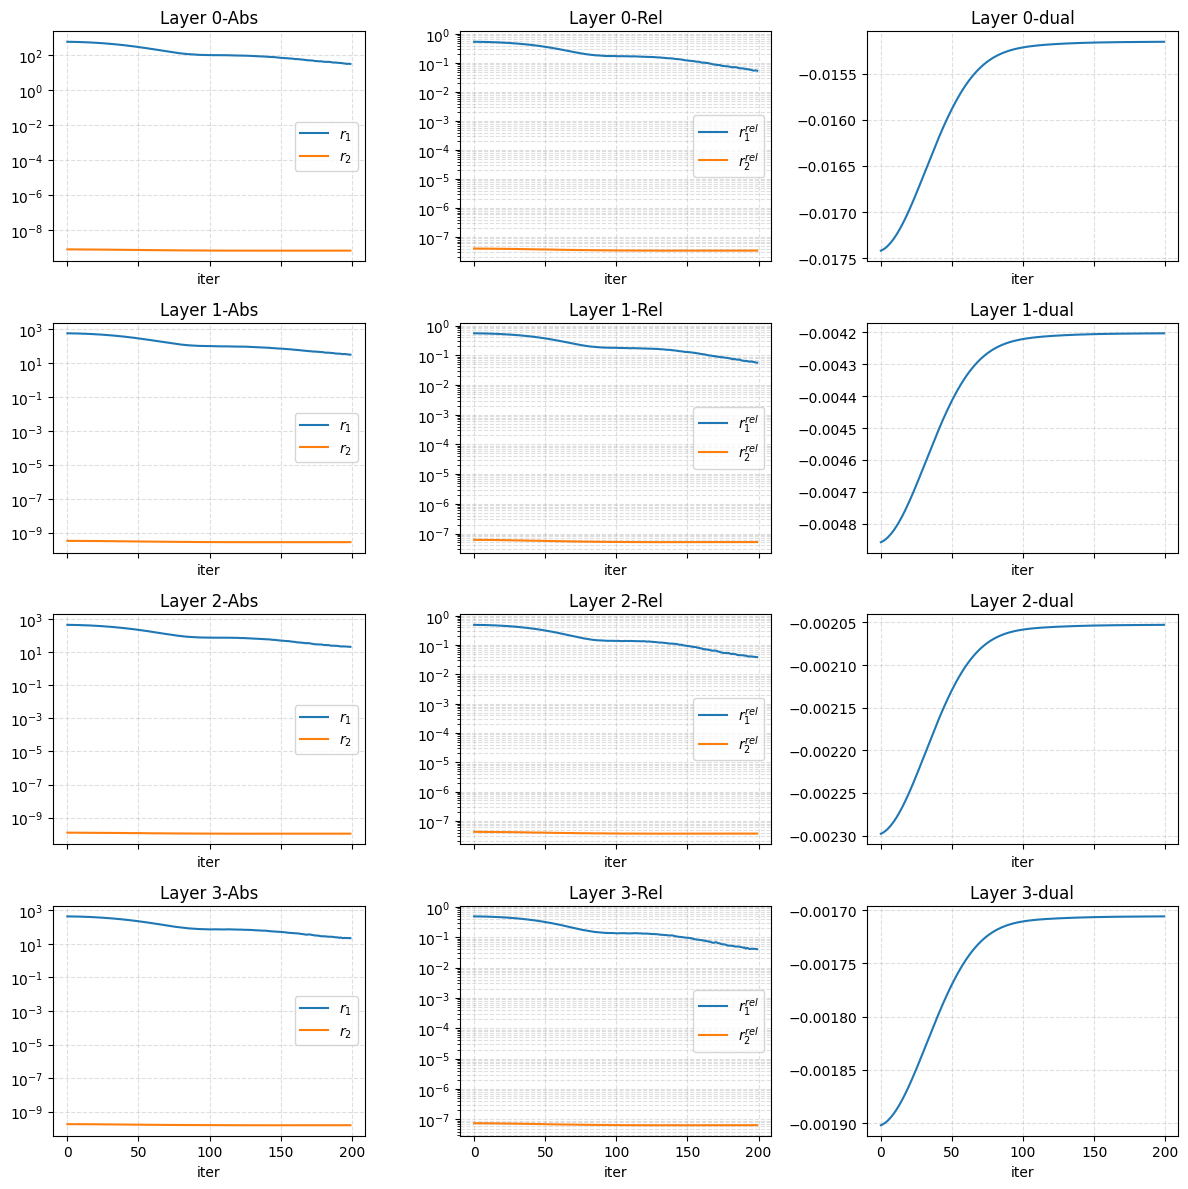

In [4]:
it = 0
print(f"iteration={it}")
plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=50


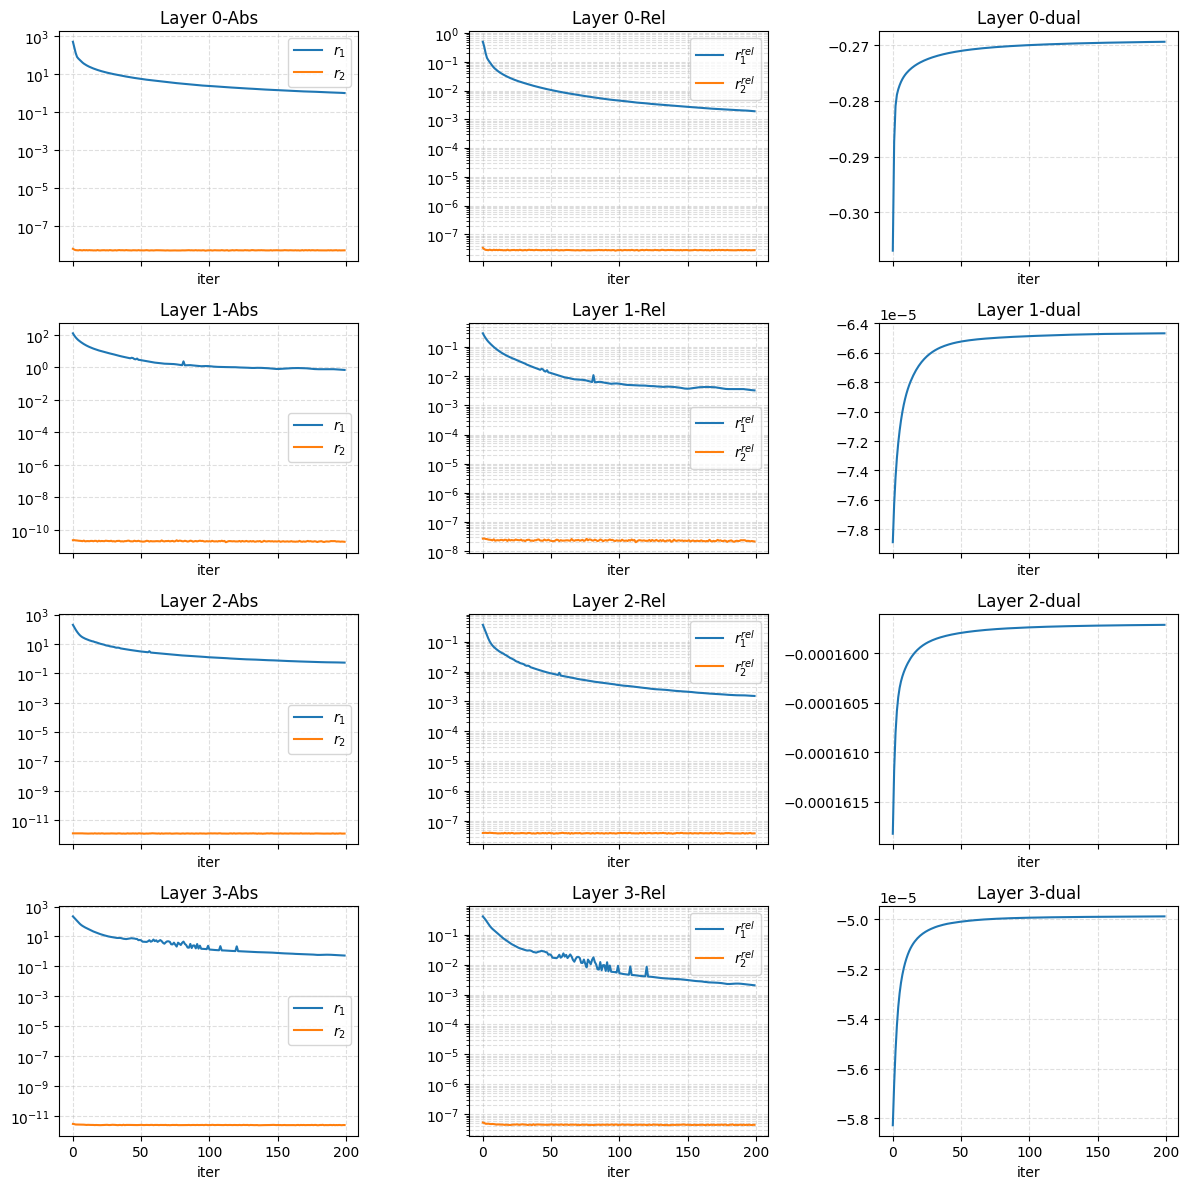

In [5]:
it = 50
print(f"iteration={it}")
plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=-1


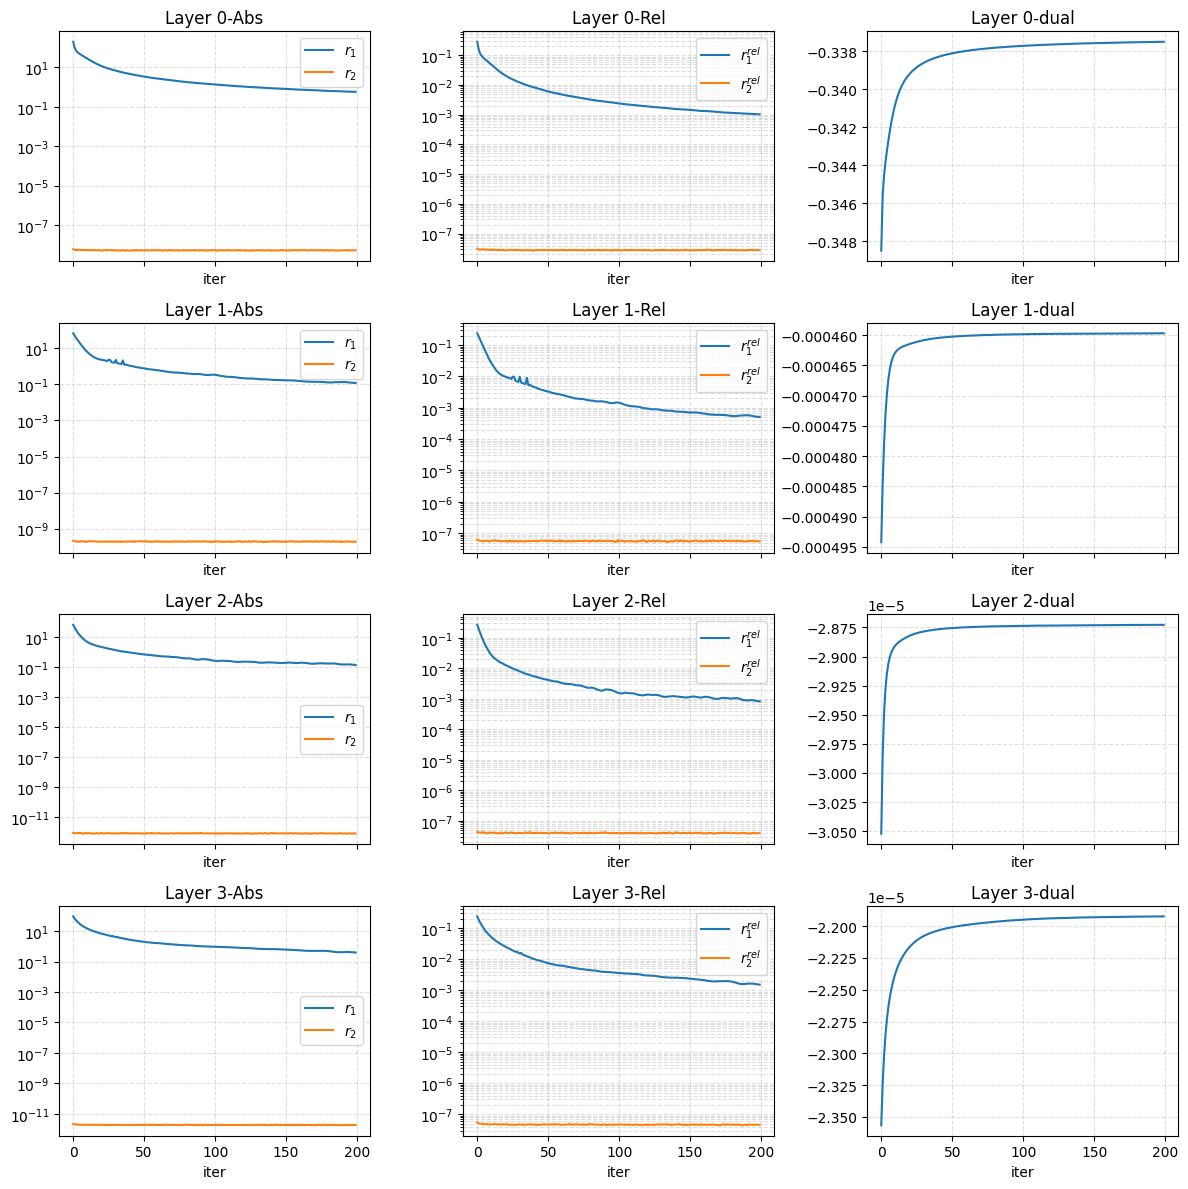

In [7]:
it = -1
print(f"iteration={it}")
plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

In [6]:
import pandas as pd

it0 = logger.pdhg_residuals[-1]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx,
        "W_q_norm": layer_res["W_q_norm"],
        "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"],
        "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"],
        "dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
df

,layer,W_q_norm,W_k_norm,G_q_norm,G_k_norm,Y_norm,dual_vals
0,0,3.225378,1.698156,0.158584,0.100478,0.557142,-0.337495
1,1,0.238425,0.127012,0.003168,0.001320,0.002678,-0.000460
2,2,0.942948,2.493666,0.000007,0.000020,0.000154,-0.000029
3,3,0.842772,0.672782,0.000035,0.000021,0.000128,-0.000022
